# Libraries

In [55]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Flatten, Dense, Dropout, Embedding, concatenate, Bidirectional, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from textwrap import wrap
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

# Load Dataset and Tokenize Captions

In [57]:
df = pd.read_csv(r"C:/Users/hassa/captions.txt")

df['caption'] = df['caption'].apply(lambda x: x.lower())
df['caption'] = df['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
df['caption'] = df['caption'].apply(lambda x: x.replace("\s+", " "))
df['caption'] = df['caption'].apply(lambda x: "start " + x + " end")

captions = df['caption'].tolist()

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(captions)
vocabulary_size = len(tokenizer.word_index) + 1
max_sequence_length = max(len(i.split()) for i in captions)
print(captions[1])
tokenizer.texts_to_sequences([captions[1]])[0]

start a girl going into a wooden building . end


[3, 1, 19, 316, 64, 1, 196, 117, 2]

# Display Sample Images With Captions

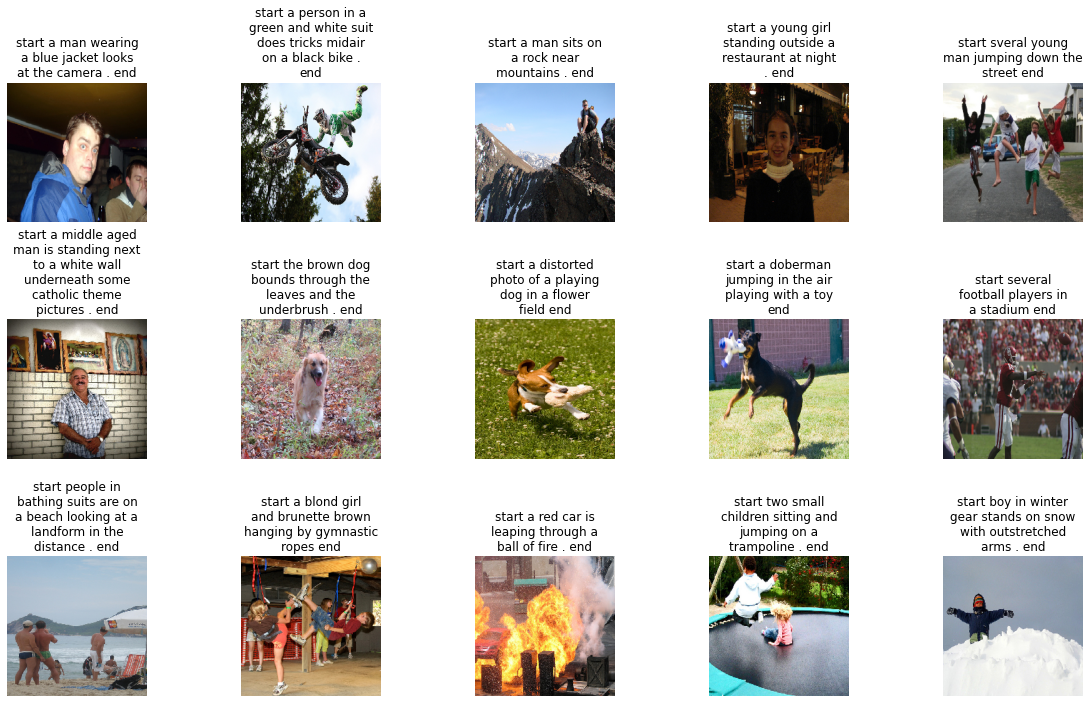

In [58]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/Users/hassa/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")
display_images(df.sample(15))

In [59]:
images_path = r'C:/Users/hassa/Images'

images = df['image'].unique().tolist()
train_images, test_images = train_test_split(images, test_size=0.15, random_state=42)

# Load ResNet50 Model for Images

In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_output = resnet.layers[-1].output
resnet_output = GlobalMaxPooling2D()(resnet_output)

# Extract Features From Images

In [61]:
image_features = {}
for image_name in tqdm(df['image'].unique().tolist(), desc="Extracting image features"):
    image_path = os.path.join(images_path, image_name)
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = tf.keras.applications.resnet50.preprocess_input(image_array)
    features = resnet.predict(image_array, verbose=0)
    image_features[image_name] = features

Extracting image features: 100%|███████████████████████████████████████████████████| 8091/8091 [40:59<00:00,  3.29it/s]


# Dataloader Class

In [17]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, df, x, y, batch_size, directory, tokenizer, v, m, features, shuffle=True):
        self.df = df.copy()
        self.x = x
        self.y = y
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.v = v
        self.m = m
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        self.indexes = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.df.iloc[batch_indexes]

        images = []
        sequences = []
        targets = []

        for _, row in batch_data.iterrows():
            image_name, caption = row[self.x], row[self.y]
            image_feature = self.features[image_name]
            sequence = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(sequence)):
                in_sequence, out_sequence = sequence[:i], sequence[i]
                in_sequence = pad_sequences([in_sequence], maxlen=self.m)[0]
                out_sequence = to_categorical([out_sequence], num_classes=self.v)[0]

                image_feature = np.reshape(image_feature, (7, 7, 2048))
                images.append(image_feature)
                sequences.append(in_sequence)
                targets.append(out_sequence)
        return (np.array(images), np.array(sequences)), np.array(targets)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def get_tf_dataset(self):
        output_signature = (
            (
                tf.TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32),
                tf.TensorSpec(shape=(None, self.m), dtype=tf.int32)
            ),
            tf.TensorSpec(shape=(None, self.v), dtype=tf.float32)
        )

        def generator_func():
            for i in range(len(self)):
                yield tuple(self[i])  #yielding a tuple as per requirement

        return tf.data.Dataset.from_generator(generator_func, output_signature=output_signature)

# Building a Hybrid Model for Image Captioning

In [18]:
EMBEDDING_DIM = 256
GRU_UNITS = 512
DENSE_UNITS = 256

# Define model inputs
image_input = Input(shape=(7, 7, 2048))  # Adjusted shape
caption_input = Input(shape=(max_sequence_length,))

# Embedding layer for captions
caption_embedding = Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIM)(caption_input)

# Bidirectional GRU layer for captions
caption_gru = Bidirectional(GRU(units=GRU_UNITS, return_sequences=True))(caption_embedding)
caption_gru = Bidirectional(GRU(units=GRU_UNITS))(caption_gru)

# Reshape image features to match the shape of caption features
reshaped_image_input = GlobalMaxPooling2D()(image_input)
reshaped_image_input = Dense(GRU_UNITS)(reshaped_image_input)

# Concatenate image features with caption features
merged = concatenate([reshaped_image_input, caption_gru])

# Apply dropout and dense layers
merged = Dropout(0.5)(merged)
merged = Dense(DENSE_UNITS, activation='relu')(merged)
merged = Dropout(0.5)(merged)

# Output layer
output = Dense(vocabulary_size, activation='softmax')(merged)

# Define and compile the model
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.summary()

# Train and Test Generator

In [19]:
path = r'C:/Users/hassa/Images'
traindata = df[df['image'].isin(train_images)]
testdata = df[df['image'].isin(test_images)]

train_generator = DataLoader(df=traindata, x='image', y='caption', batch_size=128, directory=path,
                             tokenizer=tokenizer, v=vocabulary_size, m=max_sequence_length, features=image_features)
val_generator = DataLoader(df=testdata, x='image', y='caption', batch_size=128, directory=path,
                           tokenizer=tokenizer, v=vocabulary_size, m=max_sequence_length, features=image_features)

# Callbacks for Model Training

In [20]:
model_name = "ann_model.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.2, min_lr=0.00000001)

# Training the Model

In [21]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator,
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - loss: 8.3528 
Epoch 1: val_loss improved from inf to 5.62745, saving model to ann_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1561s 48s/step - loss: 8.3141 - val_loss: 5.6274 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - loss: 5.5153 
Epoch 2: val_loss improved from 5.62745 to 5.03490, saving model to ann_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1925s 58s/step - loss: 5.5117 - val_loss: 5.0349 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - loss: 5.0409 
Epoch 3: val_loss improved from 5.03490 to 4.73528, saving model to ann_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1838s 56s/step - loss: 5.0390 - val_loss: 4.7353 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - loss: 4.7421 
Epoch 4: val_loss improved from 4.73528 to 4.51084, saving model to ann_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1796s 54s/step - loss: 4.7406 - val_loss: 4.5108 - learning_rate: 0.0010
Epoc

In [ ]:
# Load the saved model
# model = load_model("ann_model.keras")

# Testing the Model

In [25]:
#generate captions for test images
def generate_caption(image_features, tokenizer, model, max_sequence_length):
    start = 'start'
    caption = [start]
    generated_words = set()  #to avoid repetitive words
    for i in range(max_sequence_length):
        sequence = tokenizer.texts_to_sequences([start])[0]
        sequence = pad_sequences([sequence], maxlen=max_sequence_length)
        prediction = model.predict([image_features, sequence])             #testing here
        prediction = np.argmax(prediction)
        word = None
        for k, l in tokenizer.word_index.items():
            if l == prediction:
                word = k
                break
        if word is None:
            break
        if word == 'end':
            break
        if word in generated_words:  # Check if word has already been generated
            continue
        generated_words.add(word)  
        start = start + ' ' + word
        caption.append(word)
    return ' '.join(caption)

In [26]:
test_data = df[df['image'].isin(test_images)].sample(15)
test_data.reset_index(drop=True, inplace=True)
len(test_data)

15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━

<Figure size 1440x1440 with 0 Axes>

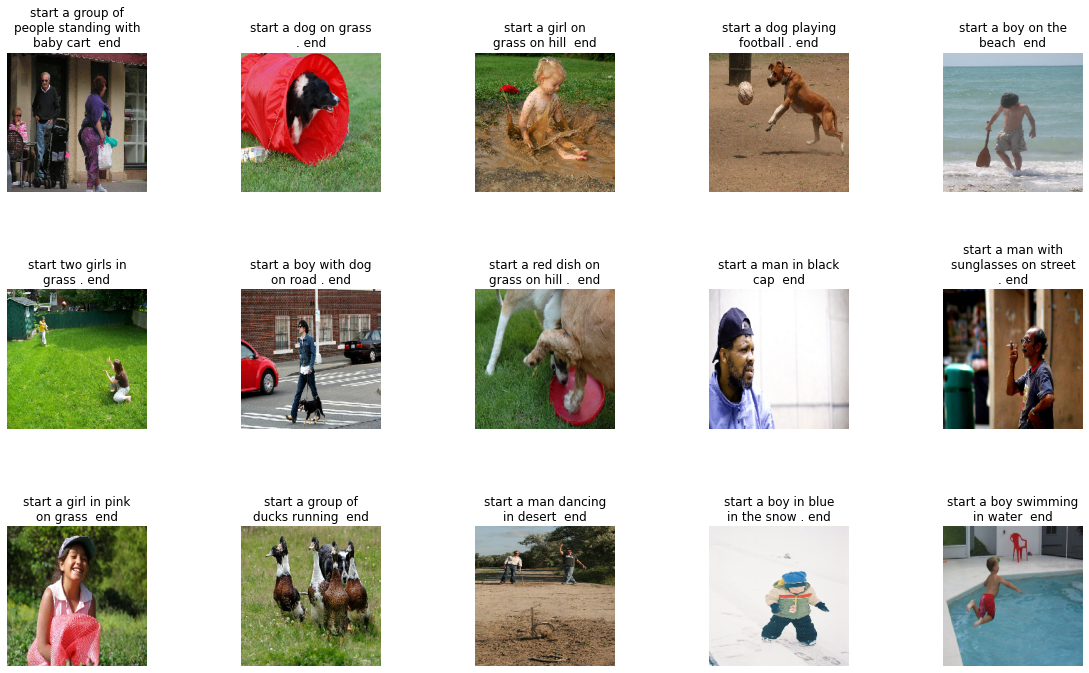

In [27]:
plt.figure(figsize=(20, 20))
for i, row in test_data.head(15).iterrows():
    image_path = os.path.join(images_path, row['image'])
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)
    feature = image_features[row['image']]
    caption = generate_caption(feature, tokenizer, model, max_sequence_length)
    plt.subplot(5, 5, i+1)
    plt.imshow(image.squeeze())
    plt.title("\n".join(wrap(caption, 20)))
    plt.axis("off")

def calculate_bleu_score(df, tokenizer, model, max_sequence_length):
    references = []
    predictions = []

    for i, row in df.iterrows():
        image_feature = image_features[row['image']]
        caption = generate_caption(image_feature, tokenizer, model, max_sequence_length)

        references.append(row['caption'].split())
        predictions.append(caption.split())

    return corpus_bleu(references, predictions)

bleu_score = calculate_bleu_score(df[df['image'].isin(test_images)], tokenizer, model, max_sequence_length)
print(f"BLEU Score on Test Data: {bleu_score}")

---

**Note:** We have tried our best to provide accurate results in this notebook. However, these results may not be entirely accurate, and contributions or corrections are encouraged. Thank you!
